In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
from typing import Dict
from torchvision.models import wide_resnet50_2, Wide_ResNet50_2_Weights
import shutil

In [ ]:
# Data Augmentation for the training dataset
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data Augmentation for the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

: 

In [ ]:
train_dataset = datasets.ImageFolder(root='data/pellis_training/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='data/pellis_training/test', transform=test_transforms)

: 

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Caminho para o diretório de treino
train_dir_path = Path('/kaggle/input/dataset-original/pellis_training/train')

# Lista de imagens no diretório de treino
train_images = list(train_dir_path.rglob('*/*.jpg'))

# Seleciona uma imagem aleatoriamente
img_path = np.random.choice(train_images)

# Carrega a imagem
img = Image.open(img_path)

# Obtendo o nome da classe
class_name = img_path.parent.name

# Exibe a imagem
plt.imshow(img)
plt.title(class_name)
plt.axis('off')
plt.show()


ValueError: 'a' cannot be empty unless no samples are taken

: 

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Caminho para o diretório de treino
test_dir_path = Path('/kaggle/input/dataset-original/pellis_training/test')

# Lista de imagens no diretório de treino
test_images = list(test_dir_path.rglob('*/*.jpg'))

# Seleciona uma imagem aleatoriamente
img_path = np.random.choice(test_images)

# Carrega a imagem
img = Image.open(img_path)

# Obtendo o nome da classe
class_name = img_path.parent.name

# Exibe a imagem
plt.imshow(img)
plt.title(class_name)
plt.axis('off')
plt.show()


ValueError: 'a' cannot be empty unless no samples are taken

: 

In [ ]:
img_array = np.array(img)

# Plotting with matplotlib
plt.imshow(img_array)
plt.title(f'Image class: {class_name} | Image shape: {img_array.shape} -> (H, W, C)')
plt.axis('off')

: 

In [ ]:
# Testing transforms on the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f'Original Image | {img_array.shape} -> (H, W, C)')

# Apply transforms
img_tensor = train_transforms(img)
img_tensor = img_tensor.numpy().transpose((1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(img_tensor)
plt.axis('off')
plt.title(f'Transformed Image | {img_tensor.shape} -> (H, W, C)')
plt.show()

: 

In [ ]:
# Getting class names from the training dataset as a list
class_names = train_dataset.classes

class_names

['1', '2 profundo', '2 superficial', '3', 'Não queimadura']

: 

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Cria os carregadores de dados
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS,
                         pin_memory=True)

# Inspecionar os rótulos no DataLoader
for images, labels in train_loader:
    unique_labels = set(labels.cpu().numpy())
    print(f"Unique labels in train_loader: {unique_labels}")
    break

for images, labels in test_loader:
    unique_labels = set(labels.cpu().numpy())
    print(f"Unique labels in test_loader: {unique_labels}")
    break

print(f"Number of classes in train_dataset: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")

Unique labels in train_loader: {0, 1, 2, 3}
Unique labels in test_loader: {0}
Number of classes in train_dataset: 5
Class names: ['1', '2 profundo', '2 superficial', '3', 'Não queimadura']


: 

In [ ]:
# Getting first batch of data
img, label = next(iter(train_loader))

# Checking the shape of the image and label
img.shape, label.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

: 

In [ ]:
from torchvision.models import convnext_small, ConvNeXt_Small_Weights

# Carrega os pesos do ImageNet
weights = ConvNeXt_Small_Weights.IMAGENET1K_V1

# Inicializa o modelo com os pesos
model = convnext_small(weights=weights)


: 

In [ ]:

# Congelar as camadas da ResNet50
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[-1].in_features

class ModifiedConvNext(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ModifiedConvNext, self).__init__()
        self.base_model = base_model
        self.base_model.classifier = nn.Identity()  # Remove the original classifier
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),  # 3 classes para queimaduras de grau 1, 2 e 3
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x



: 

In [ ]:

class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Outras camadas do teu modelo
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(196608, 512)  # Ajusta esse valor conforme necessário
        self.fc2 = nn.Linear(512, num_classes)  # num_classes é o número de classes que você tem

    def forward(self, x):
        # Passa por outras camadas do teu modelo
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x


: 

In [ ]:
model = ModifiedConvNext(model, num_classes).to(device)


: 

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# model = model.to(device)

: 

In [ ]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: optim.Optimizer,
               device: torch.device) -> Dict[str, float]:
    # Assuring that the model is in device (GPU or CPU)
    model.to(device)

    # Set the model to train mode
    model.train()

    # Initialize loss and metrics
    train_loss, correct_predictions, total_predictions = 0.0, 0, 0
    all_preds, all_labels = [], []

    # Looping through the dataloader
    for images, labels in dataloader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate the accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data).item()
        total_predictions += len(preds)

        # Collect predictions and labels for metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate the average loss and accuracy
    train_loss /= len(dataloader)
    train_accuracy = correct_predictions / total_predictions

    # Calculate precision, recall, and F1 score
    train_precision = precision_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    train_f1 = f1_score(all_labels, all_preds, average='macro')

    return {
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1
    }

: 

In [ ]:
def testing_step(model: nn.Module,
                 dataloader: DataLoader,
                 loss_fn: nn.Module,
                 device: torch.device) -> Dict[str, float]:
    # Assuring that the model is in device (GPU or CPU)
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Initialize loss and metrics
    test_loss, correct_predictions, total_predictions = 0.0, 0, 0
    all_preds, all_labels = [], []

    # Looping through the dataloader
    with torch.inference_mode():
        for images, labels in dataloader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            # Calculate the accuracy
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data).item()
            total_predictions += len(preds)

            # Collect predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the average loss and accuracy
    test_loss /= len(dataloader)
    test_accuracy = correct_predictions / total_predictions

    # Calculate precision, recall, and F1 score
    test_precision = precision_score(all_labels, all_preds, average='macro')
    test_recall = recall_score(all_labels, all_preds, average='macro')
    test_f1 = f1_score(all_labels, all_preds, average='macro')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }

: 

In [ ]:
def training(model: nn.Module,
             train_loader: DataLoader,
             test_loader: DataLoader,
             loss_fn: nn.Module,
             optimizer: optim.Optimizer,
             device: torch.device,
             num_epochs: int) -> Dict[str, float]:
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_precision': [],
        'test_recall': [],
        'test_f1': []
    }

    for epoch in tqdm(range(num_epochs)):
        train_results = train_step(model, train_loader, loss_fn, optimizer, device)
        test_results = testing_step(model, test_loader, loss_fn, device)
        
        history['train_loss'].append(train_results['train_loss'])
        history['train_accuracy'].append(train_results['train_accuracy'])
        history['train_precision'].append(train_results['train_precision'])
        history['train_recall'].append(train_results['train_recall'])
        history['train_f1'].append(train_results['train_f1'])
        
        history['test_loss'].append(test_results['test_loss'])
        history['test_accuracy'].append(test_results['test_accuracy'])
        history['test_precision'].append(test_results['test_precision'])
        history['test_recall'].append(test_results['test_recall'])
        history['test_f1'].append(test_results['test_f1'])
        
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 20)
        print(f"""
              Train Loss: {train_results['train_loss']:.4f}, 
              Train Accuracy: {train_results['train_accuracy']:.4f},
              Train Precision: {train_results['train_precision']:.4f}, 
              Train Recall: {train_results['train_recall']:.4f}, 
              Train F1: {train_results['train_f1']:.4f}
          """)
        print(f"""
              Test Loss: {test_results['test_loss']:.4f}, 
              Test Accuracy: {test_results['test_accuracy']:.4f}, 
              Test Precision: {test_results['test_precision']:.4f}, 
              Test Recall: {test_results['test_recall']:.4f}, 
              Test F1: {test_results['test_f1']:.4f}
          """)
        print()

    return history

: 

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    break


torch.Size([32, 3, 256, 256])


: 

In [ ]:
import torch
import torch.nn as nn  # Importa o módulo nn aqui
import torch.optim as optim
from tqdm import tqdm


# Define a função de perda
loss_fn = nn.CrossEntropyLoss()

# Adiciona isso no começo do código, junto com as outras importações
from time import time

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
NUM_EPOCHS = 30
start_time = time()
model_results = training(model, train_loader, test_loader, loss_fn, optimizer, device, NUM_EPOCHS)
end_time = time()

total_time = end_time - start_time
print(f'Total training time: {total_time // 60:.0f}m {total_time % 60:.0f}s')
print("Training results: ", model_results)


  0%|                                           | 0/30 [00:00<?, ?it/s]

  3%|█▏                                 | 1/30 [00:58<28:21, 58.66s/it]

Epoch 1/30
--------------------

              Train Loss: 1.2721, 
              Train Accuracy: 0.4853,
              Train Precision: 0.4795, 
              Train Recall: 0.2934, 
              Train F1: 0.2781
          

              Test Loss: 1.1022, 
              Test Accuracy: 0.5039, 
              Test Precision: 0.4418, 
              Test Recall: 0.4071, 
              Test F1: 0.3968
          



  7%|██▎                                | 2/30 [01:57<27:23, 58.69s/it]

Epoch 2/30
--------------------

              Train Loss: 1.0375, 
              Train Accuracy: 0.5782,
              Train Precision: 0.5340, 
              Train Recall: 0.4893, 
              Train F1: 0.5033
          

              Test Loss: 1.0146, 
              Test Accuracy: 0.5709, 
              Test Precision: 0.5644, 
              Test Recall: 0.5043, 
              Test F1: 0.4707
          



 10%|███▌                               | 3/30 [02:55<26:21, 58.56s/it]

Epoch 3/30
--------------------

              Train Loss: 0.9396, 
              Train Accuracy: 0.6175,
              Train Precision: 0.5928, 
              Train Recall: 0.5486, 
              Train F1: 0.5618
          

              Test Loss: 0.9811, 
              Test Accuracy: 0.5965, 
              Test Precision: 0.5664, 
              Test Recall: 0.5470, 
              Test F1: 0.5040
          



 13%|████▋                              | 4/30 [03:54<25:20, 58.49s/it]

Epoch 4/30
--------------------

              Train Loss: 0.8406, 
              Train Accuracy: 0.6662,
              Train Precision: 0.6462, 
              Train Recall: 0.6146, 
              Train F1: 0.6265
          

              Test Loss: 0.9242, 
              Test Accuracy: 0.6417, 
              Test Precision: 0.6148, 
              Test Recall: 0.6054, 
              Test F1: 0.5966
          



 17%|█████▊                             | 5/30 [04:52<24:21, 58.44s/it]

Epoch 5/30
--------------------

              Train Loss: 0.7806, 
              Train Accuracy: 0.6786,
              Train Precision: 0.6710, 
              Train Recall: 0.6288, 
              Train F1: 0.6451
          

              Test Loss: 1.0559, 
              Test Accuracy: 0.5925, 
              Test Precision: 0.5787, 
              Test Recall: 0.6070, 
              Test F1: 0.5710
          



 20%|███████                            | 6/30 [05:52<23:33, 58.90s/it]

Epoch 6/30
--------------------

              Train Loss: 0.7511, 
              Train Accuracy: 0.6990,
              Train Precision: 0.6919, 
              Train Recall: 0.6612, 
              Train F1: 0.6733
          

              Test Loss: 0.9166, 
              Test Accuracy: 0.6555, 
              Test Precision: 0.6222, 
              Test Recall: 0.6289, 
              Test F1: 0.6164
          



 23%|████████▏                          | 7/30 [06:51<22:33, 58.83s/it]

Epoch 7/30
--------------------

              Train Loss: 0.7147, 
              Train Accuracy: 0.7203,
              Train Precision: 0.7069, 
              Train Recall: 0.6816, 
              Train F1: 0.6925
          

              Test Loss: 0.9302, 
              Test Accuracy: 0.6339, 
              Test Precision: 0.6210, 
              Test Recall: 0.6036, 
              Test F1: 0.5957
          



 27%|█████████▎                         | 8/30 [07:49<21:33, 58.80s/it]

Epoch 8/30
--------------------

              Train Loss: 0.6538, 
              Train Accuracy: 0.7466,
              Train Precision: 0.7453, 
              Train Recall: 0.7119, 
              Train F1: 0.7269
          

              Test Loss: 0.8698, 
              Test Accuracy: 0.6575, 
              Test Precision: 0.6250, 
              Test Recall: 0.6239, 
              Test F1: 0.6173
          



 30%|██████████▌                        | 9/30 [08:48<20:32, 58.69s/it]

Epoch 9/30
--------------------

              Train Loss: 0.6052, 
              Train Accuracy: 0.7615,
              Train Precision: 0.7626, 
              Train Recall: 0.7260, 
              Train F1: 0.7414
          

              Test Loss: 0.9531, 
              Test Accuracy: 0.6476, 
              Test Precision: 0.6268, 
              Test Recall: 0.6426, 
              Test F1: 0.6244
          



 33%|███████████▎                      | 10/30 [09:46<19:32, 58.64s/it]

Epoch 10/30
--------------------

              Train Loss: 0.5775, 
              Train Accuracy: 0.7809,
              Train Precision: 0.7780, 
              Train Recall: 0.7537, 
              Train F1: 0.7651
          

              Test Loss: 0.9039, 
              Test Accuracy: 0.6634, 
              Test Precision: 0.6331, 
              Test Recall: 0.6219, 
              Test F1: 0.6233
          



 37%|████████████▍                     | 11/30 [10:45<18:34, 58.67s/it]

Epoch 11/30
--------------------

              Train Loss: 0.5332, 
              Train Accuracy: 0.7973,
              Train Precision: 0.7948, 
              Train Recall: 0.7814, 
              Train F1: 0.7873
          

              Test Loss: 0.9316, 
              Test Accuracy: 0.6417, 
              Test Precision: 0.6130, 
              Test Recall: 0.5789, 
              Test F1: 0.5869
          



 40%|█████████████▌                    | 12/30 [11:44<17:36, 58.68s/it]

Epoch 12/30
--------------------

              Train Loss: 0.5163, 
              Train Accuracy: 0.8082,
              Train Precision: 0.8118, 
              Train Recall: 0.7848, 
              Train F1: 0.7971
          

              Test Loss: 0.9473, 
              Test Accuracy: 0.6496, 
              Test Precision: 0.6269, 
              Test Recall: 0.6227, 
              Test F1: 0.6220
          



 43%|██████████████▋                   | 13/30 [12:42<16:36, 58.60s/it]

Epoch 13/30
--------------------

              Train Loss: 0.4766, 
              Train Accuracy: 0.8197,
              Train Precision: 0.8212, 
              Train Recall: 0.8016, 
              Train F1: 0.8109
          

              Test Loss: 1.0335, 
              Test Accuracy: 0.6476, 
              Test Precision: 0.6228, 
              Test Recall: 0.6015, 
              Test F1: 0.5953
          



 47%|███████████████▊                  | 14/30 [13:41<15:36, 58.55s/it]

Epoch 14/30
--------------------

              Train Loss: 0.4366, 
              Train Accuracy: 0.8286,
              Train Precision: 0.8298, 
              Train Recall: 0.8072, 
              Train F1: 0.8178
          

              Test Loss: 1.1080, 
              Test Accuracy: 0.6417, 
              Test Precision: 0.6206, 
              Test Recall: 0.6186, 
              Test F1: 0.6094
          



 50%|█████████████████                 | 15/30 [14:39<14:38, 58.57s/it]

Epoch 15/30
--------------------

              Train Loss: 0.4130, 
              Train Accuracy: 0.8395,
              Train Precision: 0.8339, 
              Train Recall: 0.8254, 
              Train F1: 0.8294
          

              Test Loss: 1.0396, 
              Test Accuracy: 0.6516, 
              Test Precision: 0.6145, 
              Test Recall: 0.6343, 
              Test F1: 0.6204
          



 53%|██████████████████▏               | 16/30 [15:38<13:39, 58.56s/it]

Epoch 16/30
--------------------

              Train Loss: 0.4082, 
              Train Accuracy: 0.8510,
              Train Precision: 0.8560, 
              Train Recall: 0.8365, 
              Train F1: 0.8457
          

              Test Loss: 1.0567, 
              Test Accuracy: 0.6476, 
              Test Precision: 0.6204, 
              Test Recall: 0.5942, 
              Test F1: 0.5988
          



 57%|███████████████████▎              | 17/30 [16:36<12:41, 58.54s/it]

Epoch 17/30
--------------------

              Train Loss: 0.3558, 
              Train Accuracy: 0.8609,
              Train Precision: 0.8597, 
              Train Recall: 0.8476, 
              Train F1: 0.8534
          

              Test Loss: 1.0783, 
              Test Accuracy: 0.6496, 
              Test Precision: 0.6219, 
              Test Recall: 0.6405, 
              Test F1: 0.6275
          



 60%|████████████████████▍             | 18/30 [17:35<11:42, 58.55s/it]

Epoch 18/30
--------------------

              Train Loss: 0.3475, 
              Train Accuracy: 0.8713,
              Train Precision: 0.8711, 
              Train Recall: 0.8626, 
              Train F1: 0.8668
          

              Test Loss: 1.1706, 
              Test Accuracy: 0.6654, 
              Test Precision: 0.6352, 
              Test Recall: 0.6307, 
              Test F1: 0.6305
          



 63%|█████████████████████▌            | 19/30 [18:33<10:43, 58.47s/it]

Epoch 19/30
--------------------

              Train Loss: 0.3465, 
              Train Accuracy: 0.8793,
              Train Precision: 0.8815, 
              Train Recall: 0.8642, 
              Train F1: 0.8724
          

              Test Loss: 1.1972, 
              Test Accuracy: 0.6535, 
              Test Precision: 0.6298, 
              Test Recall: 0.6349, 
              Test F1: 0.6250
          



 67%|██████████████████████▋           | 20/30 [19:32<09:45, 58.56s/it]

Epoch 20/30
--------------------

              Train Loss: 0.2954, 
              Train Accuracy: 0.8892,
              Train Precision: 0.8927, 
              Train Recall: 0.8817, 
              Train F1: 0.8870
          

              Test Loss: 1.1745, 
              Test Accuracy: 0.6339, 
              Test Precision: 0.6045, 
              Test Recall: 0.5869, 
              Test F1: 0.5914
          



 70%|███████████████████████▊          | 21/30 [20:30<08:46, 58.55s/it]

Epoch 21/30
--------------------

              Train Loss: 0.3055, 
              Train Accuracy: 0.8783,
              Train Precision: 0.8827, 
              Train Recall: 0.8741, 
              Train F1: 0.8783
          

              Test Loss: 1.1682, 
              Test Accuracy: 0.6339, 
              Test Precision: 0.5984, 
              Test Recall: 0.5939, 
              Test F1: 0.5868
          



 73%|████████████████████████▉         | 22/30 [21:29<07:48, 58.56s/it]

Epoch 22/30
--------------------

              Train Loss: 0.2795, 
              Train Accuracy: 0.9006,
              Train Precision: 0.8980, 
              Train Recall: 0.8922, 
              Train F1: 0.8950
          

              Test Loss: 1.1609, 
              Test Accuracy: 0.6811, 
              Test Precision: 0.6449, 
              Test Recall: 0.6591, 
              Test F1: 0.6497
          



 77%|██████████████████████████        | 23/30 [22:28<06:50, 58.66s/it]

Epoch 23/30
--------------------

              Train Loss: 0.2845, 
              Train Accuracy: 0.8992,
              Train Precision: 0.8974, 
              Train Recall: 0.8895, 
              Train F1: 0.8934
          

              Test Loss: 1.2294, 
              Test Accuracy: 0.6693, 
              Test Precision: 0.6458, 
              Test Recall: 0.6337, 
              Test F1: 0.6304
          



 80%|███████████████████████████▏      | 24/30 [23:27<05:52, 58.69s/it]

Epoch 24/30
--------------------

              Train Loss: 0.2472, 
              Train Accuracy: 0.9136,
              Train Precision: 0.9143, 
              Train Recall: 0.9070, 
              Train F1: 0.9106
          

              Test Loss: 1.3031, 
              Test Accuracy: 0.6476, 
              Test Precision: 0.6157, 
              Test Recall: 0.6292, 
              Test F1: 0.6167
          



 83%|████████████████████████████▎     | 25/30 [24:25<04:53, 58.64s/it]

Epoch 25/30
--------------------

              Train Loss: 0.2401, 
              Train Accuracy: 0.9111,
              Train Precision: 0.9094, 
              Train Recall: 0.9040, 
              Train F1: 0.9066
          

              Test Loss: 1.2274, 
              Test Accuracy: 0.6594, 
              Test Precision: 0.6248, 
              Test Recall: 0.6475, 
              Test F1: 0.6319
          



 87%|█████████████████████████████▍    | 26/30 [25:24<03:54, 58.63s/it]

Epoch 26/30
--------------------

              Train Loss: 0.2236, 
              Train Accuracy: 0.9180,
              Train Precision: 0.9135, 
              Train Recall: 0.9094, 
              Train F1: 0.9114
          

              Test Loss: 1.2489, 
              Test Accuracy: 0.6634, 
              Test Precision: 0.6417, 
              Test Recall: 0.6207, 
              Test F1: 0.6289
          



 90%|██████████████████████████████▌   | 27/30 [26:22<02:55, 58.55s/it]

Epoch 27/30
--------------------

              Train Loss: 0.2423, 
              Train Accuracy: 0.9076,
              Train Precision: 0.9039, 
              Train Recall: 0.8949, 
              Train F1: 0.8992
          

              Test Loss: 1.2016, 
              Test Accuracy: 0.6555, 
              Test Precision: 0.6304, 
              Test Recall: 0.6215, 
              Test F1: 0.6242
          



 93%|███████████████████████████████▋  | 28/30 [27:21<01:57, 58.57s/it]

Epoch 28/30
--------------------

              Train Loss: 0.2131, 
              Train Accuracy: 0.9250,
              Train Precision: 0.9288, 
              Train Recall: 0.9192, 
              Train F1: 0.9238
          

              Test Loss: 1.2655, 
              Test Accuracy: 0.6476, 
              Test Precision: 0.6262, 
              Test Recall: 0.6157, 
              Test F1: 0.6180
          



 97%|████████████████████████████████▊ | 29/30 [28:19<00:58, 58.55s/it]

Epoch 29/30
--------------------

              Train Loss: 0.2147, 
              Train Accuracy: 0.9220,
              Train Precision: 0.9214, 
              Train Recall: 0.9179, 
              Train F1: 0.9196
          

              Test Loss: 1.2921, 
              Test Accuracy: 0.6654, 
              Test Precision: 0.6380, 
              Test Recall: 0.6388, 
              Test F1: 0.6336
          



100%|██████████████████████████████████| 30/30 [29:18<00:00, 58.60s/it]

Epoch 30/30
--------------------

              Train Loss: 0.1997, 
              Train Accuracy: 0.9275,
              Train Precision: 0.9298, 
              Train Recall: 0.9239, 
              Train F1: 0.9268
          

              Test Loss: 1.3338, 
              Test Accuracy: 0.6594, 
              Test Precision: 0.6420, 
              Test Recall: 0.6371, 
              Test F1: 0.6354
          

Total training time: 29m 18s
Training results:  {'train_loss': [1.2721031175719366, 1.0375000806081862, 0.9396239452891879, 0.8405508238171774, 0.7805827042413136, 0.7511007374241239, 0.7147252786727178, 0.6538362361135936, 0.6052150586767803, 0.5775153438250223, 0.5332134988099809, 0.5163277699833825, 0.47660956259757753, 0.43661996059947544, 0.41301782618439387, 0.4081512632824126, 0.3557768501932659, 0.34747889590641806, 0.34650809471569366, 0.2953567038925867, 0.30552564348493305, 0.2794841167236131, 0.28449358850244494, 0.24717326675142562, 0.24009069244539927, 0.223634845

: 

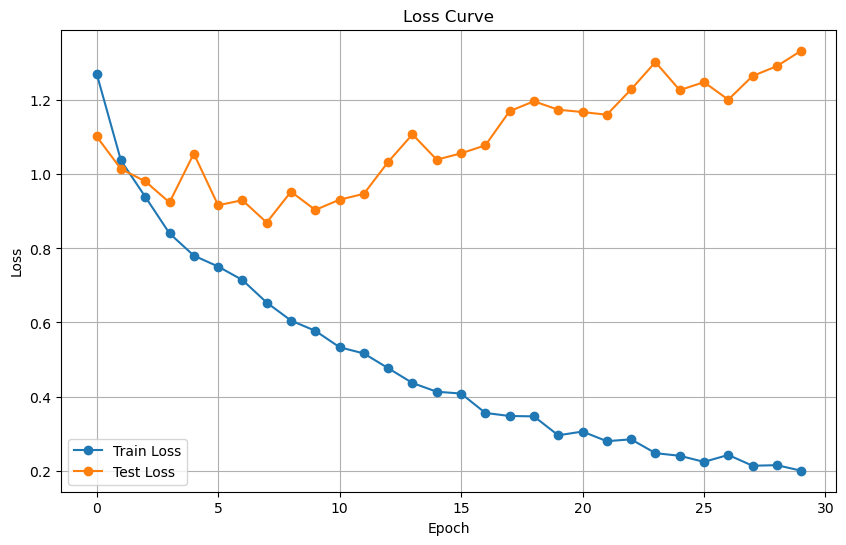

: 

In [ ]:
def plot_loss_curve(history: Dict[str, float]):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['test_loss'], label='Test Loss', marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curve(model_results)


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(model: nn.Module,
                          dataloader: DataLoader,
                          device: torch.device,
                          class_names: list) -> None:
    model.eval()
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for images, labels in tqdm(dataloader, desc='Predicting...'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()

: 

Predicting...: 100%|███████████████████| 16/16 [00:08<00:00,  1.84it/s]


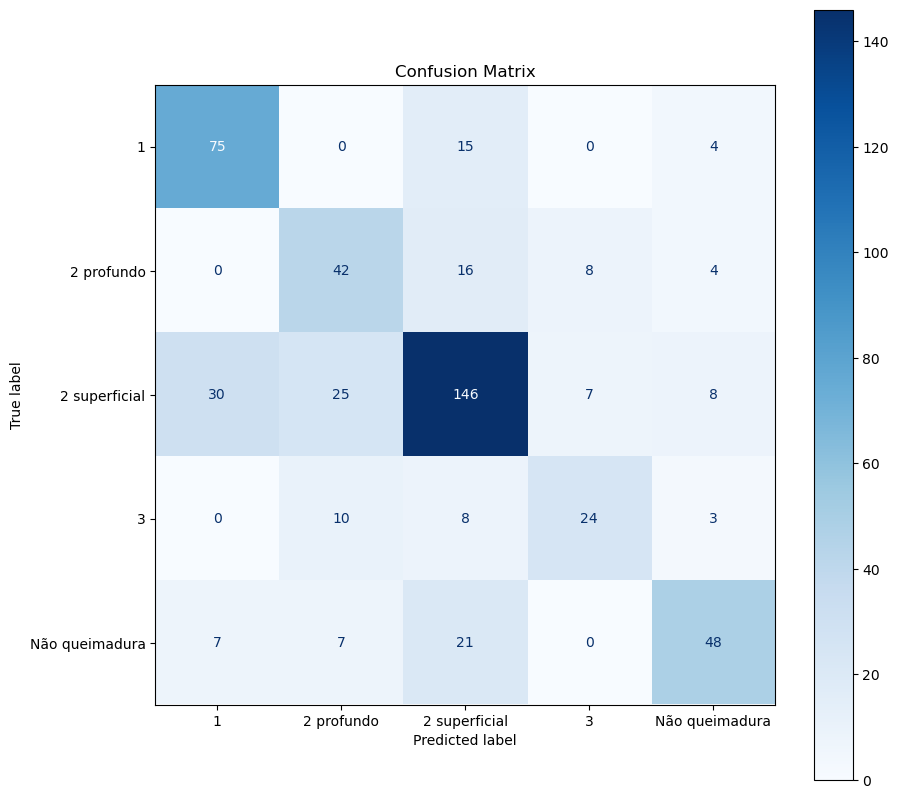

: 

In [ ]:
# Plotting the confusion matrix
plot_confusion_matrix(model, test_loader, device, class_names)